# Infer ***golgi*** - part 4️⃣

--------------
## **OBJECTIVE**

### <input type="checkbox"/> Infer sub-cellular component  ***golgi***  
Segment the ***golgi*** from a single channel (membrane marker). This workflow was optimized for images of fluorescently tagged sialyltransferase1 (SiT1), a membrane protein. The Golgi has both the classical cisternae structure as well as small golgi derived vesciles, so we are utilizing two segmentation methods to idenfity the entire Golgi structure.

---------------------
## infer ***golgi complex***
### summary of steps 

➡️ **EXTRACTION**
- **`STEP 1`** - Select a channel for segmentation

    - select single channel containing the golgi marker (channel number = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

  - rescale intensity of composite image (min=0, max=1)
  - median filter (median size = user input)
  - gaussian filter (sigma = user input)

**CORE PROCESSING**
- **`STEP 3`** - Global + local thresholding (AICSSeg – MO)

    - apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

- **`STEP 4`** - Thin segmentation (Topology preserving)

    - apply topology preserved thinning function from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (thinning amount, minimum thickness = user input)

- **`STEP 5`** - ‘Dot’ thresholding method (AICSSeg)

    - apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)

- **`STEP 6`** - Combine Segmentations (logical or)

    - combine the two segmentations with logical *OR*

**POST-PROCESSING**
- **`STEP 7`** - Remove small holes and objects

  - fill holes (hole size = user input)
  - remove small objects (object size = user input)
  - filter method (method = user input)

**POST-POST-PROCESSING**
- **`STEP 8`** - Label objects

  - label unique golgi objects based on connectivity

**EXPORT** ➡️
- save labeled ***golgi*** (golgi, GL) as unsigned integer 16-bit tif files


> Generally following the Allen Cell Segmenter procedure for segmentation of Golgi from the [sialyltransferase 1 (ST6GAL1)](https://www.allencell.org/cell-observations/category/golgi-apparatus) marker. Sourced from: this [script](https://github.com/AllenCell/aics-segmentation/blob/main/aicssegmentation/structure_wrapper/seg_st6gal1.py).

---------------------
## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook.

In [ ]:
from pathlib import Path
import os

import numpy as np

from aicssegmentation.core.utils import topology_preserving_thinning
import napari
from napari.utils.notebook_display import nbscreenshot

from infer_subc.core.file_io import (read_czi_image,
                                                                    # read_ome_image,
                                                                    export_inferred_organelle,
                                                                    # import_inferred_organelle,
                                                                    list_image_files,
                                                                    sample_input)

from infer_subc.core.img import *

%load_ext autoreload
%autoreload 2


## **LOAD AND READ IN IMAGE FOR PROCESSING**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [ ]:
### USER INPUT REQUIRED ###
# If using the sample data, select which cell type you would like analyze ("neuron" or "astrocyte"):
# If not using the sample data, set cell_type to None
sample_data_type = "neuron"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0

# If you are not using the sample data, please edit "USER SPECIFIED" as necessary.
## Define the path to the directory that contains the input image folder.
data_root_path = Path("USER SPECIFIED")

# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
im_type = "USER SPECIFIED"

## Specify which subfolder that contains the input data and the input data file extension
in_data_path = data_root_path / "USER SPECIFIED"

## Specify the output folder to save the segmentation outputs if.
## If its not already created, the code below will creat it for you
out_data_path = data_root_path / "USER SPECIFIED"

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
# If sample_data_type is set to "neuron" or "astrocyte", then the sample data is used and the directories are set
if sample_data_type != None:
    data_root_path, im_type, in_data_path, out_data_path = sample_input(sample_data_type)

In [3]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

img_file_list = list_image_files(in_data_path,im_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [4]:
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

# ***EXTRACTION prototype - golgi***

## **`STEP 1` - Select a channel for segmentation**

- select single channel containing the golgi marker (channel number = user input)

In [5]:
###################
# INPUT
###################
GOLGI_CH = 2
raw_golgi = select_channel_from_raw(img_data, GOLGI_CH)

# ***PRE-PROCESSING prototype - golgi***

## **`STEP 2` - Rescale and smooth image**

- rescale intensity of composite image (min=0, max=1)
- median filter (median size = user input)
- gaussian filter (sigma = user input)

In [6]:
###################
# PRE_PROCESSING
###################
median_sz = 0
gauss_sig = 0

struct_img =  scale_and_smooth(raw_golgi,
                               median_size = median_sz, 
                               gauss_sigma = gauss_sig)

# ***CORE-PROCESSING prototype - golgi***

## **`STEP 3` - Global + local thresholding (AICSSeg – MO)**

- apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

In [7]:
###################
# CORE_PROCESSING
###################
################################
# segment the majority of the golgi with this global and local thresholding method
thresh_method = 'ave_tri_med'
cell_wise_min_area = 1200
thresh_adj = .9

bw = masked_object_thresh(struct_img, 
                          global_method=thresh_method, 
                          cutoff_size=cell_wise_min_area, 
                          local_adjust=thresh_adj)

## **`STEP 4` - Thin segmentation (Topology preserving)**

- apply topology preserved thinning function from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (thinning amount, minimum thickness = user input)

In [8]:
# thin segmentation with maintain a minimal required thickness
thin_dist = 1
thin_dist_preserve = 8

bw_thin = topology_preserving_thinning(bw, thin_dist_preserve, thin_dist)

## **`STEP 5` - ‘Dot’ thresholding method (AICSSeg)**

- apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)

In [9]:
# segment small round structures with this (golgi vesicles)
dot_scale_1 = 0.5
dot_cut_1 = 0.1

dot_scale_2 = 0
dot_cut_2 = 0

dot_scale_3 = 0
dot_cut_3 = 0

dot_method = '3D'

bw_extra = dot_filter_3(struct_img,
                        dot_scale_1,
                        dot_cut_1,
                        dot_scale_2,
                        dot_cut_2,
                        dot_scale_3,
                        dot_cut_3,
                        dot_method)

## **`STEP 6` - Combine Segmentations (logical or)**

- combine the two segmentations with logical *OR*

In [10]:
# combine the two segmentations together
bw_combine = np.logical_or(bw_extra, bw_thin)

# ***POST-PROCESSING prototype - golgi***

## **`STEP 7` - Remove small holes and objects**

- fill holes (hole size = user input)
- remove small objects (object size = user input)
- filter method (method = user input)

In [11]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 0

small_object_width = 2

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw_combine, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

# ***POST-POST-PROCESSING prototype - golgi***

## **`STEP 8` - Label objects**

- label unique golgi objects based on connectivity

In [12]:
###################
# LABELING
###################
golgi_labels = label_uint16(cleaned_img2)

In [13]:
golgi_labels.dtype

dtype('uint16')

## **Visualize with `napari` 1**
Visualize the first-pass segmentation and labeling with `napari`.

In [14]:
viewer = napari.Viewer(title = "golgi",
                       ndisplay=3)

In [15]:
viewer.add_image(
    struct_img,
    scale = scale,
    name = "Golgi body Intensities")

viewer.add_image(
    cleaned_img2,
    scale = scale,
    opacity=0.3,
    name = "Golgi Segmentation")

viewer.add_labels(
    golgi_labels,
    scale = scale,
    opacity=0.3,
    name = "Golgi Labels")

<Labels layer 'Golgi Labels' at 0x24b0018d4e0>

# ***EXTRACTION prototype - golgi***

- save labeled ***golgi*** (golgi, GL) as unsigned integer 16-bit tif files

In [16]:
out_file_n = export_inferred_organelle(golgi_labels, "golgi", meta_dict, out_data_path)

saved file: 20230727_C2-121_conditioned_well 4_cell 3_untreated_Linear unmixing_0_cmle.ome-golgi


#### &#x1F6D1; &#x270D; **User Input Required:**

In [ ]:
## When using the sample data in part 2, quantification is carried out on both the neuron and astrocyte data through
## batch processing. to_batch = True copies the segmentation to the batch processing file location in addition to the
## segmentation folder.

to_batch = True

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
if to_batch and sample_data_type == 'neuron' or sample_data_type == 'astrocyte':
    out_file_b = export_inferred_organelle(golgi_labels, "golgi", meta_dict, Path(os.getcwd()).parents[1] / "sample_data" /  "batch_example" / "seg")

# **Define `_infer_golgi` function**

> ###### 📝 **these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use**

In [18]:
##########################
#  infer_golgi
##########################
def _infer_golgi(
            in_img: np.ndarray,
            golgi_ch: int,
            median_sz: int,
            gauss_sig: float,
            mo_method: str,
            mo_adjust: float,
            mo_cutoff_size: int,
            min_thickness: int,
            thin_dist: int,
            dot_scale_1: float,
            dot_cut_1: float,
            dot_scale_2: float,
            dot_cut_2: float,
            dot_scale_3: float,
            dot_cut_3: float,
            dot_method: str,
            min_hole_w: int,
            max_hole_w: int,
            small_obj_w: int,
            fill_filter_method: str
        ) -> np.ndarray:

    """
    Procedure to infer golgi from linearly unmixed input.

   Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    min_thinkness: 
        Half of the minimum width you want to keep from being thinned.
        For example, when the object width is smaller than 4, you don't
        want to make this part even thinner (may break the thin object
        and alter the topology), you can set this value as 2.
    thin_dist: 
        the amount to thin (has to be an positive integer). The number of
         pixels to be removed from outter boundary towards center.
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    
    Returns
    -------------
    golgi_object
        mask defined extent of golgi object
    """

    ###################
    # EXTRACT
    ###################    
    golgi = select_channel_from_raw(in_img, golgi_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    golgi =  scale_and_smooth(golgi,
                              median_size = median_sz, 
                              gauss_sigma = gauss_sig)
    ###################
    # CORE_PROCESSING
    ###################
    bw = masked_object_thresh(golgi, global_method=mo_method, cutoff_size=mo_cutoff_size, local_adjust=mo_adjust)

    bw_thin = topology_preserving_thinning(bw, min_thickness, thin_dist)

    bw_extra = dot_filter_3(golgi, dot_scale_1, dot_cut_1, dot_scale_2, dot_cut_2, dot_scale_3, dot_cut_3, dot_method)

    bw = np.logical_or(bw_extra, bw_thin)
    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(bw, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1


# **Test `_infer_golgi` function**

In [19]:
_golgi_object =  _infer_golgi(
    img_data,
    GOLGI_CH,
    median_sz,
    gauss_sig,
    thresh_method,
    thresh_adj,
    cell_wise_min_area,
    thin_dist_preserve,
    thin_dist,
    dot_scale_1,
    dot_cut_1,
    dot_scale_2,
    dot_cut_2,
    dot_scale_3,
    dot_cut_3,
    dot_method,
    hole_min_width,
    hole_max_width,
    small_object_width,
    fill_filter_method) 

_golgi_object.dtype

dtype('uint16')

In [20]:
np.all(golgi_labels == _golgi_object)

False

## **Visualize with `napari` 2**

In [ ]:
viewer.add_labels(
    _golgi_object,
    scale = scale,
    opacity=0.3,
    name = "Golgi body Object")

<Image layer 'Golgi body Object' at 0x24b0215b2e0>

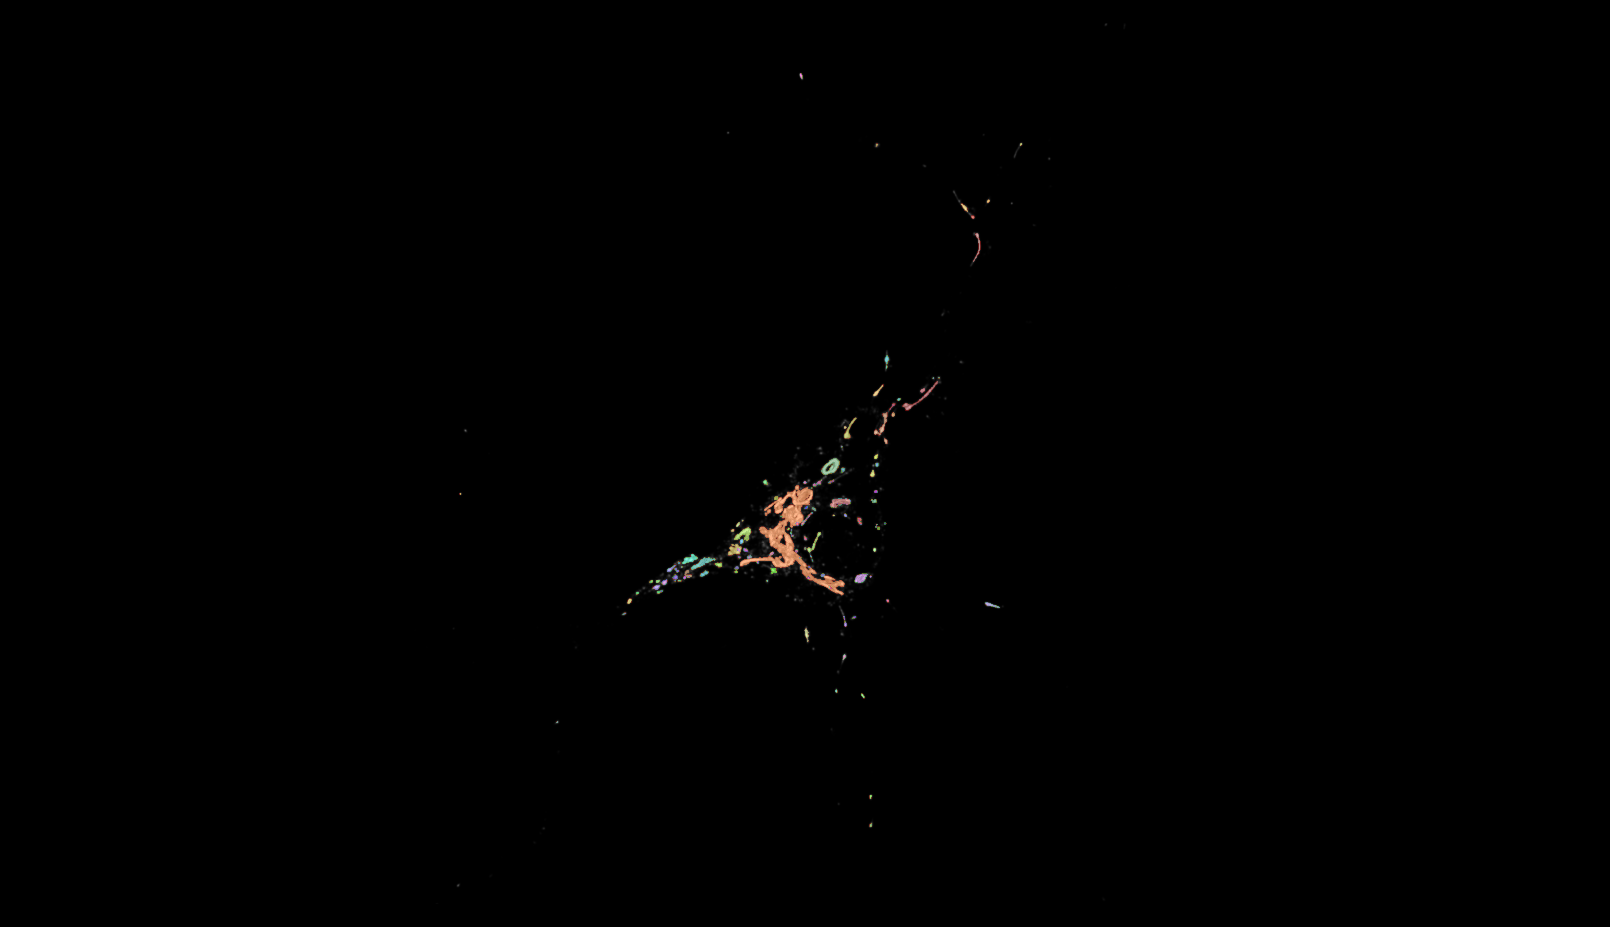

In [22]:
nbscreenshot(viewer, canvas_only=True)

In [23]:
viewer.close()

-------------
### NEXT: INFER PEROXISOME

proceed to [1.5_infer_peroxisome.ipynb](./1.5_infer_peroxisome.ipynb)
